In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from pathlib import Path

In [2]:
train_dt = pd.read_excel("data/train.xlsx")
test_dt = pd.read_excel("data/test.xlsx")
combi_dt = pd.concat([train_dt, test_dt], ignore_index=True)
combi_dt['dt'] = pd.to_datetime(combi_dt['dt'])
sorted_dt = combi_dt.sort_values(by='dt')
sorted_dt = sorted_dt.drop_duplicates()
result_file = 'sorted.xlsx'
sorted_dt.to_excel(result_file, index=False)


In [3]:
combi_dt.shape
print("\nПропущенные значения:")
print(combi_dt.isnull().sum())
print("\nКоличество дубликатов:")
print(combi_dt.duplicated().sum())
print("\nОписательная статистика:")
combi_dt.describe()


Пропущенные значения:
dt                  0
Цена на арматуру    0
dtype: int64

Количество дубликатов:
0

Описательная статистика:


,dt,Цена на арматуру
count,428,428.000000
mean,2019-02-07 12:00:00,39557.920561
min,2015-01-05 00:00:00,21000.000000
25%,2017-01-21 06:00:00,31650.000000
50%,2019-02-07 12:00:00,36150.000000
75%,2021-02-23 18:00:00,43162.500000
max,2023-03-13 00:00:00,79000.000000
std,NaN,13052.612976


In [4]:
print("Столбцы в sorted_dt:", sorted_dt.columns)
print("Столбцы в test_dt:", test_dt.columns)

Столбцы в sorted_dt: Index(['dt', 'Цена на арматуру'], dtype='object')
Столбцы в test_dt: Index(['dt', 'Цена на арматуру'], dtype='object')


In [5]:
for df in [sorted_dt, test_dt]:
    df["dt"] = pd.to_datetime(df["dt"], errors='coerce')
    df["year"] = df["dt"].dt.year
    df["month"] = df["dt"].dt.month
    df["day"] = df["dt"].dt.day
    df["week"] = df["dt"].dt.isocalendar().week
    df.drop(columns=["dt"], errors="ignore", inplace=True)

In [6]:
print(sorted_dt.columns)
sorted_dt = sorted_dt.sort_values(by=['year', 'month', 'day', 'week'])

Index(['Цена на арматуру', 'year', 'month', 'day', 'week'], dtype='object')


In [7]:
print(sorted_dt)

     Цена на арматуру  year  month  day  week
0               32900  2015      1    5     2
1               32500  2015      1   12     3
2               32000  2015      1   19     4
3               30700  2015      1   26     5
4               30300  2015      2    2     6
..                ...   ...    ...  ...   ...
423             44500  2023      2   13     7
424             46000  2023      2   20     8
425             49200  2023      2   27     9
426             53700  2023      3    6    10
427             55500  2023      3   13    11

[428 rows x 5 columns]


In [8]:
X = sorted_dt.drop(columns=['Цена на арматуру']).iloc[:-1, :]  # Замените "target" на название целевой переменной
y = sorted_dt['Цена на арматуру'].values[1:]
X['Price_target'] = y
X['Price_source'] = sorted_dt['Цена на арматуру'].values[:-1]
price_diff = X['Price_source'] - X['Price_target']
y = X['Price_target']
X = X.drop(columns=['Price_target'])
X = X.drop([0])
X['Price_Diff'] = price_diff.values[:-1]
X

,year,month,day,week,Price_source,Price_Diff
1,2015,1,12,3,32500,400
2,2015,1,19,4,32000,500
3,2015,1,26,5,30700,1300
4,2015,2,2,6,30300,400
5,2015,2,9,7,30300,0
...,...,...,...,...,...,...
422,2023,2,6,6,44500,-1700
423,2023,2,13,7,44500,0
424,2023,2,20,8,46000,-1500
425,2023,2,27,9,49200,-3200


In [9]:
print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")


Размер X: (426, 6)
Размер y: (427,)


In [10]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y = y[X.index]

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)
model0 = LGBMRegressor(n_estimators=5000, max_depth=7, learning_rate=0.03,
                       objective='mae', metric='mae',
                       random_state=42, verbose=100)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)
model0.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
           callbacks=[early_stopping(stopping_rounds=100)])

y_pred = model0.predict(X_valid)

y_pred_holdout = model0.predict(X_holdout)

mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")



[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.031250
[LightGBM] [Debug] init for col-wise cost 0.000215 seconds, init for row-wise cost 0.000636 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 272, number of used features: 6
[LightGBM] [Info] Start training from score 36850.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[L

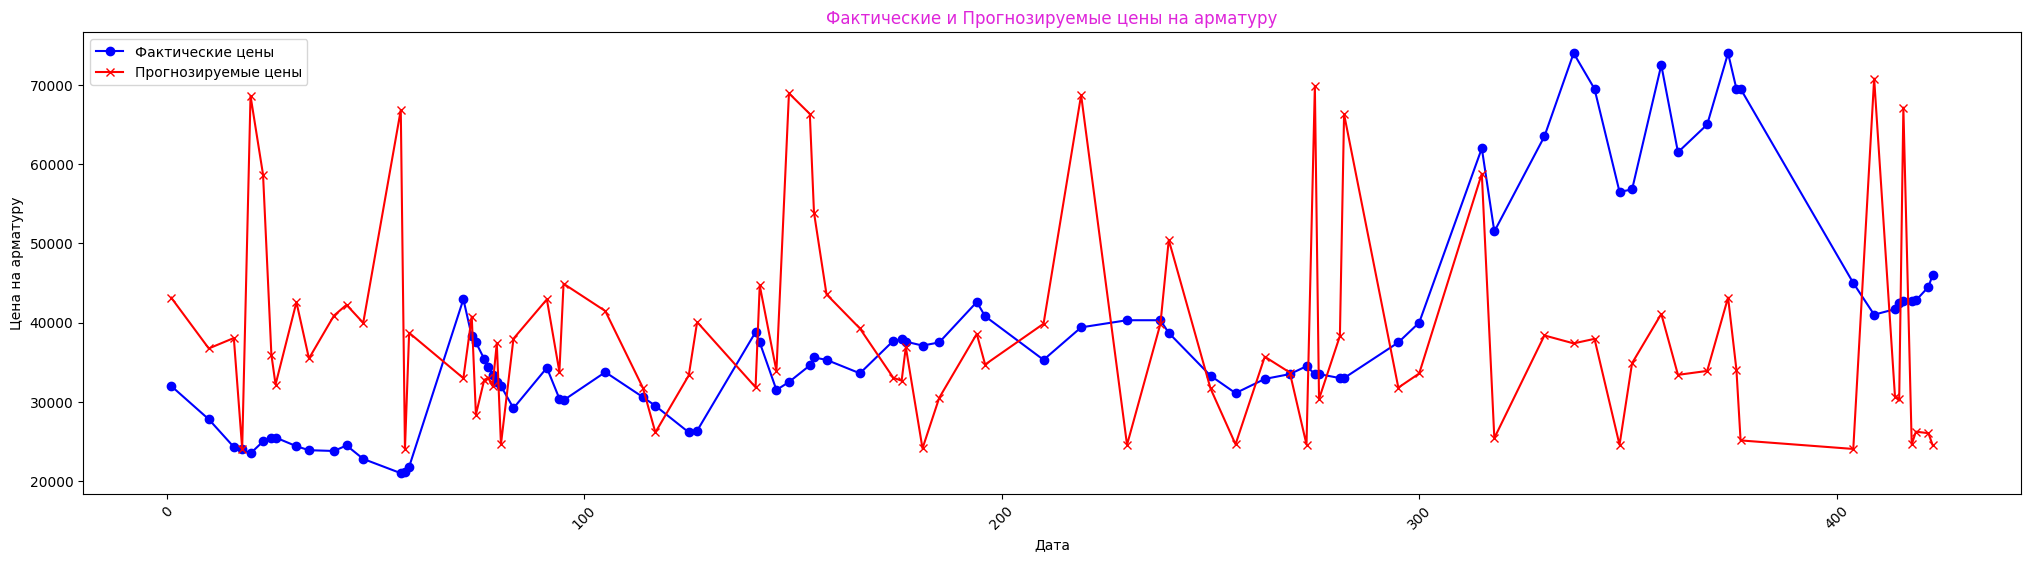

In [11]:
y_holdout = y_holdout.sort_index()
y_pred_holdout = pd.Series(y_pred_holdout, index=y_holdout.index).sort_index()

plt.figure(figsize=(25, 6))
plt.plot(y_holdout.index, y_holdout.values, label="Фактические цены", color='blue', marker='o')
plt.plot(y_holdout.index, y_pred_holdout, label="Прогнозируемые цены", color='red', marker='x')

plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Фактические и Прогнозируемые цены на арматуру", color='#de25da')
plt.xticks(rotation=45)
plt.show()

In [12]:
import joblib
joblib.dump(model0, "LGBMRegressor.pkl")

['LGBMRegressor.pkl']

In [13]:
#column = 'Цена на арматуру'
#plt.figure(figsize=(8, 5))
#sns.histplot(df[column], bins=30, kde=True)
#plt.title("Распределение цен на арматуру")
#plt.xlabel("Цена")
#plt.ylabel("Частота")
#plt.show()

In [14]:
#print(df.columns)  # Выведет все столбцы DataFrame

In [15]:
#df['dt'] = pd.to_datetime(df['dt'])
#df.set_index('dt', inplace=True)
#plt.figure(figsize=(12, 6))
#plt.plot(df.index, df['Цена на арматуру'], label='Цена на арматуру', color='b')
#plt.title('Динамика цен на арматуру')
#plt.xlabel('Дата')
#plt.ylabel('Цена')
#plt.legend()
#plt.grid()
#plt.show()

In [16]:
#fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
#decompose = seasonal_decompose(df[['Цена на арматуру']])

#ax[0].set_title('Оригинал')
#ax[1].set_title('Тренд')
#ax[2].set_title('Сезонность')
#ax[3].set_title('Остаток')

#decompose.observed.plot(ax=ax[0])
#decompose.trend.plot(ax=ax[1])
#decompose.seasonal.plot(ax=ax[2])
#decompose.resid.plot(ax=ax[3]);

In [17]:
#print(df.columns)

In [18]:
#df['month'] = df.index.month
#plt.figure(figsize=(7, 5))
#sns.lineplot(x=df['month'], y=df['Цена на арматуру'], errorbar=None)
#plt.xlabel('Месяц')  # Подпись оси X
#plt.ylabel('Цена на арматуру')  # Подпись оси Y (возможно, здесь ошибка, так как строится цена на арматуру)
#plt.title('Сезонные изменения цен')  # Заголовок графика
#plt.xticks(range(1, 13), labels=[
    #'Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн',
    #'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
#plt.grid(True)
#plt.show()